In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages
# use curve_fit for Rosenbluth linear fit
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# optional: use science paper style for plots
# from matplotlib.ticker import ScalarFormatter

import scienceplots
plt.style.use('science')

import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

In [2]:
# notations in this code:
# nu: energy transfer
# cross: cross section
# Q2: four-momentum transfer squared
# qv: bold q, three-momentum transfer
# Ex: excitation energy
# W: invariant mass of the final state (W2: W squared)
# epsilon: virtual photon polarization parameter
# Theta: scattering angle
# E0: incident electron energy
# Ep: final electron energy
# Veff: effective potential (_eff is used for "effective" quantities)

In [3]:
# preset values for the analysis: (you need to update)
#____________________________________________________________________________________________________________________
# physical constants
A = 2
Z = 1
C12_factor = Z / 6
mass_nucleon = 0.938273
mass_nucleus = A * 0.931494
alpha_fine = 1 / 137

# three-momentum bin centers
qvcenters = [0.100, 0.148, 0.167, 0.205, 0.240, 0.300, 0.380, 0.475, 0.570, 0.649, 0.756, 0.991, 1.619, 1.921, 2.213, 2.500, 2.783, 3.500]
# three-momentum edges
qvbins = [0.063, 0.124, 0.158, 0.186, 0.223, 0.270, 0.340, 0.428, 0.523, 0.609, 0.702, 0.878, 1.302, 1.770, 2.067, 2.357, 2.642, 2.923, 4.500]
# four-momentum squared bin names, in string format
qvbin_names = ['[0.063,0.124]', '[0.124,0.158]', '[0.158,0.186]', '[0.186,0.223]', '[0.223,0.270]', '[0.270,0.340]', '[0.340,0.428]', '[0.428,0.523]', '[0.523,0.609]',
                '[0.609,0.702]', '[0.702,0.878]', '[0.878,1.302]', '[1.302,1.770]', '[1.770,2.067]', '[2.067,2.357]', '[2.357,2.642]', '[2.642,2.923]', '[2.923,4.500]']

# four-momentum squared bin centers
Q2centers = [0.010, 0.020, 0.026, 0.040, 0.056, 0.093, 0.120, 0.160, 0.265, 0.380, 0.500, 0.800, 1.250, 1.750, 2.250, 2.750, 3.250, 3.750]
# four-momentum squared bin edges
Q2bins = [0.004, 0.015, 0.025, 0.035, 0.045, 0.070, 0.100, 0.145, 0.206, 0.322, 0.438, 0.650, 1.050, 1.500, 2.000, 2.500, 3.000, 3.500, 4.000]
# four-momentum squared bin names, in string format
Q2bin_names = ['[0.004,0.015]', '[0.015,0.025]', '[0.025,0.035]', '[0.035,0.045]', '[0.045,0.070]', '[0.070,0.100]', '[0.100,0.145]', '[0.145,0.206]', '[0.206,0.322]',
                '[0.322,0.438]', '[0.438,0.650]', '[0.650,1.050]', '[1.050,1.500]', '[1.500,2.000]', '[2.000,2.500]', '[2.500,3.000]', '[3.000,3.500]', '[3.500,4.000]']


In [4]:
# utility functions:

# round to only 3 significant figures (for printing)
def round_sig_3(x):
    return '%s' % float('%.3g' % x)

# append a row to a dataframe
def append_row(df, row):
    return pd.concat([df, pd.DataFrame([row], columns=row.index)]).reset_index(drop=True)

# linear model for Rosenbluth fitting
def linear_model(x, a, b):
    return a * x + b

# prepare the dataframe
# "filepath" should be the path to the csv file that contains columns {'A', 'Z', 'nu', 'E0', 'ThetaDeg', 'cross', 'error', 'dataSet'}
# read dataframe from csv file
def prepare_df(filepath):

    df = pd.read_csv(filepath)
    initial_row_count = len(df)
    df = df.dropna(subset=['bc_qv_ex', 'bc_qv_w2'])
    df = df[~np.isinf(df['bc_qv_ex']) & ~np.isinf(df['bc_qv_w2'])]
    df.reset_index(drop=True, inplace=True)
    final_row_count = len(df)
    rows_dropped = initial_row_count - final_row_count
    print(f"Number of rows dropped: {rows_dropped}")

    return df

In [5]:
# load from a pre-computed data base
df = prepare_df('Data/df_H2.csv')
print(len(df))

RLRT_plot_yes = False
RLRT_pdf_yes = True
Rosenbluth_pdf_yes = False
Rosenbluth_analysis_yes = False
os.makedirs("Output", exist_ok=True)
if Rosenbluth_pdf_yes:
    Rosenbluth_pdf = PdfPages("Output/H2_Rosenbluth.pdf")
    Chi2_total = 0.0
    if Rosenbluth_analysis_yes:
        with open("Output/H2_Rosenbluth.csv", "w") as Rosenbluth_analysis:
            Rosenbluth_analysis.write("page,center,center,nu_center,slope,intercept,Chi2,DoF,Chi2/DoF\n")

Number of rows dropped: 210
5238


In [6]:
# extract and plot functions
# plt.rcParams.update({'font.size': 12, 'axes.labelsize': 12, 'axes.titlesize': 12, 'legend.fontsize': 16})

errorbar_setting = {'markersize':'0','capsize':0,'lw':0.5,'fmt':'D','elinewidth':0.8,'zorder':2,'alpha':0.5}
our_scatter_setting = {'s':6,'marker':'D','edgecolors':'black','linewidth':0.5,'zorder':4,'alpha':1}
hotta_scatter_setting = {'s':12,'marker':'D','edgecolors':'black','linewidth':0.5,'zorder':4,'alpha':1}
photo_scatter_setting = {'s':30,'color':'lime','marker':'^','edgecolors':'black','linewidth':0.5,'zorder':1}

def RLRT_extract_qvbin(df=None,bin_index=0,Rosenbluth_plot=False,bc=True):
    Ex_increments = np.array([0.0012,0.001,0.0006,0.0006,0.0006,0.0010,0.0036,0.0036,0.0036,0.0036,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002])
    W2_increments = np.array([0.01,0.002,0.002,0.014,0.018,0.01,0.008,0.032,0.06,0.018,0.04,0.12,0.12,0.12,0.12,0.24,0.24,0.24])
    qvcenter = qvcenters[bin_index]
    bin_data = df.loc[df['qvcenter'] == qvcenter].copy()
    fit = pd.DataFrame()
    Ex_inc = Ex_increments[bin_index]
    W2_inc = W2_increments[bin_index]
    Ex = 0.0
    nu = np.sqrt(mass_nucleus**2 + qvcenter**2 + 2 * mass_nucleus * Ex) - mass_nucleus
    nu_upper = np.sqrt(mass_nucleus**2 + qvcenter**2 + 2 * mass_nucleus * (Ex + Ex_inc)) - mass_nucleus
    W2 = mass_nucleon**2 + 2 * mass_nucleon * 0.05 - (qvcenter**2 - 0.05**2)

    while nu <= qvcenter:

        if nu_upper < 0.05:
            picked = bin_data.loc[(bin_data['Ex'] >= Ex) & (bin_data['Ex'] < Ex + Ex_inc)].copy()
            picked['Hbc_Sig(GeV)'] = picked['bc_qv_ex'] * picked['Hcc_Sig(GeV)']
            picked['Hbc_error(GeV)'] = picked['bc_qv_ex'] * picked['Hcc_error(GeV)']
            nu = np.sqrt(mass_nucleus**2 + qvcenter**2 + 2 * mass_nucleus * Ex) - mass_nucleus
            nu_upper = np.sqrt(mass_nucleus**2 + qvcenter**2 + 2 * mass_nucleus * (Ex + Ex_inc)) - mass_nucleus
            Ex += Ex_inc
        else:
            picked = bin_data.loc[(bin_data['W2'] >= W2) & (bin_data['W2'] < W2 + W2_inc)].copy()
            picked['Hbc_Sig(GeV)'] = picked['bc_qv_w2'] * picked['Hcc_Sig(GeV)']
            picked['Hbc_error(GeV)'] = picked['bc_qv_w2'] * picked['Hcc_error(GeV)']
            nu = np.sqrt(qvcenter**2 + W2) - mass_nucleon
            nu_upper = np.sqrt(qvcenter**2 + W2 + W2_inc) - mass_nucleon
            W2 += W2_inc

        nu_mid = (nu + nu_upper) / 2
        q2 = qvcenter**2 - nu_mid**2

        x = np.array(picked["epsilon"].values)
        if bc:
            y = np.array(picked["Hbc_Sig(GeV)"].values)
            y_err = np.array(picked["Hbc_error(GeV)"].values)
        else:
            y = np.array(picked["Hcc_Sig(GeV)"].values)
            y_err = np.array(picked["Hcc_error(GeV)"].values)
       
        if len(y) >= 2 and (np.max(x) - np.min(x)) >= 0.25:
        
            if len(y) == 2:
                x = np.concatenate([x, x])
                y = np.concatenate([y + 0.1 * y_err, y - 0.1 * y_err])
                y_err = y_err * 1.414
                y_err = np.concatenate([y_err, y_err])
                
            params, covariance = curve_fit(linear_model, x, y, sigma=y_err, absolute_sigma=True)

            a_opt, b_opt = params
            a_err, b_err = np.sqrt(np.diag(covariance))
            Chi2 = np.sum(np.square((y - linear_model(x, a_opt, b_opt)) / y_err))
            RL = a_opt / 1000
            RLerr = a_err / 1000 
            RT = (2 * b_opt * q2 / (qvcenter**2)) / 1000
            RTerr = (2 * b_err * q2 / (qvcenter**2)) / 1000
            new_row = pd.Series({'qvcenter':qvcenter,'nu':nu_mid,'RL':RL,'RLerr':RLerr,'RT':RT,'RTerr':RTerr,'Chi2':Chi2, 'num_points':len(y),'xerr':nu_mid})             
            fit = append_row(fit,new_row)
            #____________________________________________________________________________________________________________________
            
            if Rosenbluth_plot:
                fig = plt.figure(figsize=(12,6))
                plt.plot(x,linear_model(x,a_opt,b_opt),color='gray',label = 'y='+str(round(a_opt,3))
                        +'*x+'+str(round(b_opt,3))
                        +'\nRL,RT:'+str(round(RL,3))+','+str(round(RT,3))
                        +'\n$\\sigma_{RL}, \\sigma_{RT}$'+round_sig_3(RLerr)+','+round_sig_3(RTerr)
                        +'\n$\\frac{\\sigma_{RL}}{RL}, \\frac{\\sigma_{RT}}{RT}$'+round_sig_3(RLerr/RL)+','+round_sig_3(RTerr/RT))
                datasets = picked['dataSet'].unique()            
                plt.title('$q_{center}$:'+str(qvcenter)+'   $\\nu_{center}$:'+str(round(nu_mid,3))+'   $\chi^2$:'+str(round(Chi2,3))+'   DoF:'+str(len(y)-2) +'   $\\frac{\chi^2}{DoF}$:'+str(round(Chi2/(len(y)-2),3)))
                if Rosenbluth_analysis_yes:
                    with open("Output/H2_Rosenbluth.csv", "a") as Rosenbluth_analysis:
                        Rosenbluth_analysis.write(f",qvcenter,{qvcenter},{nu_mid},{a_opt},{b_opt},{Chi2},{len(y)-2},{Chi2/(len(y)-2)}\n")
                if not np.isnan(Chi2) and np.isfinite(Chi2):
                    global Chi2_total
                    Chi2_total += Chi2
                for dataset in datasets:
                    picked_dataset = picked.loc[picked['dataSet'] == dataset]
                    plt.errorbar(picked_dataset['epsilon'],picked_dataset['Hbc_Sig(GeV)'],yerr=picked_dataset['Hbc_error(GeV)'],
                                fmt ='.',capsize=3,markersize='3')
                    plt.scatter(picked_dataset['epsilon'],picked_dataset['Hbc_Sig(GeV)'],s=10, label = str(dataset))
                    for _, picked_dataset_row in picked_dataset.iterrows():
                        plt.text(picked_dataset_row['epsilon'], picked_dataset_row['Hbc_Sig(GeV)'], '$E:$'+str(picked_dataset_row['E0'])+'$\\Theta$:'+str(picked_dataset_row['ThetaDeg'])+'\n$\\nu$:'+str(round(picked_dataset_row['nu'],3))+'$Ex$:'+str(round(picked_dataset_row['Ex'],3)), fontsize=7, ha='right')
                        plt.text(picked_dataset_row['epsilon'], picked_dataset_row['Hbc_Sig(GeV)'], round_sig_3(picked_dataset_row['system_err']), fontsize=7, ha='left', color='red')
                plt.xlabel('epsilon')
                plt.ylabel('Hbc')
                plt.legend()
                Rosenbluth_pdf.savefig(fig) 
                plt.close(fig)
            #____________________________________________________________________________________________________________________
    
    fit['Ex'] = fit['nu'] - (qvcenter**2 - fit['nu']**2) / (2 * mass_nucleus)
    return fit

def RLRT_plot_qvbin(df=None,bin_indices=[0],Rosenbluth_plot=False, RLRTthisAnalysis_plot=True,
                    ChristyBodekFitTotal_plot = True, ChristyBodekFitQE_plot = True, ChristyBodekFitNoDelta_plot = False, 
                    figsize = (10,8),legend_ncol=3,subplot_adjust=0.16,bc=True):
    RL_plot_heights = np.array([0.2, 0.4, 0.4, 0.4, 0.4, 0.25, 0.15, 0.07, 0.05, 0.15, 0.15, 0.07, 0.4, 1, 0.6, 0.2, 0.2, 0.05])*1e3
    RT_plot_heights = np.array([0.05, 0.1, 0.1, 0.15, 0.15, 0.15, 0.2, 0.2, 0.2, 0.2, 0.2, 0.25, 0.25, 0.25, 0.3, 0.3, 0.35, 0.4])*1e3
    RL_plot_left = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 1, 1.5, 1.5, 1.5])
    RT_plot_left = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 1, 1.5, 1.5, 1.5])
    QE_left = [0,0,0,0,0,0,0,0,0,0,0.2,0.2,0.7,1.0,1.2,1.5,1.8,2.4]
    QE_right = [0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,3,0.9,1.5,1.8,2.0,2.3,2.6,3.3]
    RLQE_top = np.array([0.02,0.03,0.04,0.5,0.5,0.02,0.02,0.08,0.007,0.003,0.001, 0.005,0.0012,0.0006,0.0006,0.0003,0.0003,0.0003])*1e3
    RTQE_top = np.array([0.013,0.027,0.03,0.035,0.041,0.044,0.045,0.045,0.049,0.04,0.05,0.02,0.005,0.0025,0.002,0.0015,0.001,0.0008])*1e3

    handles = []
    labels = []

    fig, axs = plt.subplots(nrows=len(bin_indices), ncols=2, figsize=figsize,dpi=300)
    for i in range(len(bin_indices)):
        bin_index = bin_indices[i]
        qvcenter = qvcenters[bin_index]
        fit = RLRT_extract_qvbin(df=df,bin_index=bin_index,Rosenbluth_plot=Rosenbluth_plot,bc=bc)

        if qvcenter >= 0.31:
            fit = fit.loc[fit['Ex'] >= 0.03]
        # Christy-Bodek fit RLRT total
        ChristyBodekFit = pd.read_csv('Qvedges/'+f'Qvedge_{qvcenter}.csv',index_col = False)
        ChristyBodekFit.columns = ['qv','q2','ex','nu','RT','RL','RTQE','RLQE','RTIE','RLIE','RTE','RLE','RTNS','RLNS']    
        ChristyBodekFit['RL'] = ChristyBodekFit['RL']*1e3*C12_factor
        ChristyBodekFit['RLQE'] = ChristyBodekFit['RLQE']*1e3*C12_factor
        ChristyBodekFit['RT'] = ChristyBodekFit['RT']*1e3*C12_factor
        ChristyBodekFit['RTQE'] = ChristyBodekFit['RTQE']*1e3*C12_factor
        ChristyBodekFit['RTE'] = ChristyBodekFit['RTE']*1e3*C12_factor
        ChristyBodekFit['RLIE'] = ChristyBodekFit['RLIE']*1e3*C12_factor
        ChristyBodekFit['RTIE'] = ChristyBodekFit['RTIE']*1e3*C12_factor
        ChristyBodekFit['RLNS'] = ChristyBodekFit['RLNS']*1e3*C12_factor
        ChristyBodekFit['RTNS'] = ChristyBodekFit['RTNS']*1e3*C12_factor

        # Christy-Bodek fit RLRT total
        if ChristyBodekFitTotal_plot:        
            axs[i,0].plot(ChristyBodekFit['nu'],ChristyBodekFit["RL"],color='black',label="RL(total), RT(total) Christy-Bodek Fit",linestyle='solid')
            axs[i,1].plot(ChristyBodekFit['nu'],ChristyBodekFit["RT"],color='black',linestyle='solid')

        # Christy-Bodek fit RLRT QE only
        if ChristyBodekFitQE_plot:
            axs[i,0].plot(ChristyBodekFit['nu'],ChristyBodekFit["RLQE"],color='black',label="RL(QE), RT(QE+TE) Christy-Bodek Fit",linestyle='dashed') 
            axs[i,1].plot(ChristyBodekFit['nu'],(ChristyBodekFit["RTQE"]+ChristyBodekFit["RTE"]),color='black',linestyle='dashed')

        # Christy-Bodek fit RLRT no delta (NS + QE)
        if ChristyBodekFitNoDelta_plot:
            axs[i,0].plot(ChristyBodekFit['nu'],ChristyBodekFit["RLNS"]+ChristyBodekFit["RLQE"],color='black',label="RL(QE+NS), RT(QE+NS) Christy-Bodek Fit", linestyle='dotted')
            axs[i,1].plot(ChristyBodekFit['nu'],ChristyBodekFit["RTNS"]+ChristyBodekFit["RTQE"],color='black',linestyle='dotted')
                        

        # RL RT this analysis
        if RLRTthisAnalysis_plot:

            fit = fit[fit['RTerr'] >= 0]

            fit['RL'] = fit['RL']*1e3
            fit['RLerr'] = fit['RLerr']*1e3
            axs[i,0].scatter(fit['nu'], fit['RL'],color='red',label='RL, RT this analysis',**our_scatter_setting)
            axs[i,0].errorbar(fit['nu'], fit['RL'], yerr = fit['RLerr'], color='red', **errorbar_setting)

            fit['RT'] = fit['RT']*1e3
            fit['RTerr'] = fit['RTerr']*1e3
            axs[i,1].scatter(fit['nu'], fit['RT'],color='red',**our_scatter_setting)
            axs[i,1].errorbar(fit['nu'], fit['RT'], yerr = fit['RTerr'], color='red', **errorbar_setting)

        # These W (final state invariant mass) are put on plot for kinematic reference
        W_peaks = np.array([0.93,1.07,1.23]) 
        W_colors = ['darkorange','turquoise','slateblue']
        W_locations = 0.025-mass_nucleon+np.sqrt(qvcenter**2+W_peaks**2)
        # text_offset=0.1*W_locations[0]
        W_labels = ['','','']
        # RL_plot_height = RL_plot_heights[bin_index]
        # RT_plot_height = RT_plot_heights[bin_index]
        if qvcenter >= 0.991:
            ax_inset0 = inset_axes(axs[i,0], width="50%", height="50%", loc='upper left')
            ax_inset1 = inset_axes(axs[i,1], width="50%", height="50%", loc='upper left')
            ax_inset0.yaxis.tick_right()
            ax_inset1.yaxis.tick_right()
            
            if ChristyBodekFitTotal_plot:
                ax_inset0.plot(ChristyBodekFit['nu'],ChristyBodekFit["RL"],color='black', linestyle='solid')
                ax_inset1.plot(ChristyBodekFit['nu'],ChristyBodekFit["RT"],color='black', linestyle='solid')
            if ChristyBodekFitQE_plot:
                ax_inset0.plot(ChristyBodekFit['nu'],ChristyBodekFit["RLQE"],color='black', linestyle='dashed')
                ax_inset1.plot(ChristyBodekFit['nu'],ChristyBodekFit["RTQE"]+ChristyBodekFit["RTE"],color='black', linestyle='dashed')
            if ChristyBodekFitNoDelta_plot:
                ax_inset0.plot(ChristyBodekFit['nu'],ChristyBodekFit["RLNS"]+ChristyBodekFit["RLQE"],color='black', linestyle='dotted')
                ax_inset1.plot(ChristyBodekFit['nu'],ChristyBodekFit["RTNS"]+ChristyBodekFit["RTQE"],color='black', linestyle='dotted')
            if RLRTthisAnalysis_plot:
                ax_inset0.scatter(fit['nu'], fit['RL'],color='red',**our_scatter_setting)
                ax_inset0.errorbar(fit['nu'], fit['RL'], yerr = fit['RLerr'], color='red', **errorbar_setting, ecolor='red')
                ax_inset1.scatter(fit['nu'], fit['RT'],color='red',**our_scatter_setting)
                ax_inset1.errorbar(fit['nu'], fit['RT'], yerr = fit['RTerr'], color='red', **errorbar_setting,ecolor='red')

            ax_inset0.set_xlim(W_locations[0]*0.9,W_locations[2]*1.1)
            ax_inset1.set_xlim(W_locations[0]*0.9,W_locations[2]*1.1)
            ax_inset0.set_ylim(0,RLQE_top[bin_index]*C12_factor)
            ax_inset1.set_ylim(0,RTQE_top[bin_index]*C12_factor)

            for k in range(len(W_peaks)):
                location = W_locations[k]

                if location < qvcenter:
                    ax_inset0.axvline(x=location, color = W_colors[k], linestyle='dashdot',lw=1,label=f'$W={W_peaks[k]}$ $GeV$ '+W_labels[k])
                    ax_inset1.axvline(x=location, color = W_colors[k], linestyle='dashdot',lw=1)
            h, l = ax_inset0.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            h, l = ax_inset1.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)

        else:

            for k in range(len(W_peaks)):
                location = W_locations[k]
                if location < qvcenter:
                    axs[i,0].axvline(x=location, color = W_colors[k], linestyle='dashdot',lw=1,label=f'$W={W_peaks[k]}$ $GeV$ '+W_labels[k])
                    axs[i,1].axvline(x=location, color = W_colors[k], linestyle='dashdot',lw=1)
            
        axs[i,0].axvline(x=qvcenter, color = 'brown', linestyle='dashdot',lw=1,label=f'$Q^2=0$ $GeV^2$')
        axs[i,1].axvline(x=qvcenter, color = 'brown', linestyle='dashdot',lw=1)
        axs[i,0].set_xlim(RL_plot_left[bin_index], qvcenter*1.05)
        axs[i,1].set_xlim(RT_plot_left[bin_index], qvcenter*1.05)

        axs[i,0].set_ylim(0,RL_plot_heights[bin_index])
        axs[i,1].set_ylim(0,RT_plot_heights[bin_index])

        # plt.tight_layout()

        h, l = axs[i,0].get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
        h, l = axs[i,1].get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

        if i == len(bin_indices)-1:
            axs[i,0].set_xlabel('$\\boldsymbol{\\nu$ $\pmb(GeV)}$')
            axs[i,1].set_xlabel('$\\boldsymbol{\\nu}$ $\pmb{(GeV)}$')
        axs[i,0].set_ylabel('$\pmb{R_L}$ $\pmb{(GeV^{-1})}$')
        axs[i,1].set_ylabel('$\pmb{R_T}$ $\pmb{(GeV^{-1})}$')
        xleft, xright = axs[i,0].get_xlim()
        _,ytop = axs[i,0].get_ylim()

        axs[i,0].text(xleft+0.55*(xright-xleft),ytop*0.97,"$\pmb{\mathbf{q}=}$ "+f'{qvcenter}'+' $\pmb{GeV}$',ha='left',va='top',color='gray',zorder=5)

        xleft, xright = axs[i,1].get_xlim()
        _,ytop = axs[i,1].get_ylim()

        axs[i,1].text(xleft+0.7*(xright-xleft),ytop*0.97,"$\pmb{\mathbf{q}=}$ "+f'{qvcenter}'+' $\pmb{GeV}$',ha='left',va='top',color='gray',zorder=5)

    unique_handles = []
    unique_labels = []
    for label in labels:
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handles[labels.index(label)])
    desired_unique_labels = ['RL(total), RT(total) Christy-Bodek Fit', 'RL(QE), RT(QE+TE) Christy-Bodek Fit', 'RL, RT this analysis', '$W=0.93$ $GeV$ ', '$W=1.07$ $GeV$ ', '$W=1.23$ $GeV$ ', '$Q^2=0$ $GeV^2$']
    ordered_handles = []
    ordered_labels = []
    for label in desired_unique_labels:
        if label in unique_labels:
            index = unique_labels.index(label)
            ordered_labels.append(label)
            ordered_handles.append(unique_handles[index])

    fig.legend(ordered_handles, ordered_labels, loc='lower center', ncol=legend_ncol)
    plt.tight_layout()
    plt.subplots_adjust(bottom=subplot_adjust)
    plt.show()
    
    return fig

def RLRT_extract_Q2bin(df=None,bin_index=0,Rosenbluth_plot=False,bc=True):
    # if Ex_increments is None:
    Ex_increments=np.array([0.006,0.0025,0.005,0.005,0.003,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005])
    # if W2_increments is None:
    W2_increments=np.array([0.01,0.01,0.01,0.008,0.01,0.008,0.008,0.03,0.015,0.05,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
    
    Q2center = Q2centers[bin_index]
    
    bin_data   = df.loc[df['Q2center'] == Q2center].copy()
    fit = pd.DataFrame()
    Ex_inc = Ex_increments[bin_index]
    W2_inc = W2_increments[bin_index]
    Ex = 0.0
    nu = Ex + Q2center / (2 * mass_nucleus)
    nu_upper = Ex + Ex_inc + Q2center / (2 * mass_nucleus)
    W2 = mass_nucleon**2 + 2 * mass_nucleon * 0.05 - Q2center

    while nu < 3.5:

        if nu_upper < 0.05:
            picked = bin_data.loc[(bin_data['Ex'] >= Ex) & (bin_data['Ex'] < Ex + Ex_inc)].copy()
            picked['Hbc_Sig(GeV)'] = picked['bc_q2_ex'] * picked['Hcc_Sig(GeV)']
            picked['Hbc_error(GeV)'] = picked['bc_q2_ex'] * picked['Hcc_error(GeV)']
            nu = Ex + Q2center / (2 * mass_nucleus)
            nu_upper = Ex + Ex_inc + Q2center / (2 * mass_nucleus) 
            Ex += Ex_inc
        else:
            picked = bin_data.loc[(bin_data['W2'] >= W2) & (bin_data['W2'] < W2 + W2_inc)].copy()
            picked['Hbc_Sig(GeV)'] = picked['bc_q2_w2'] * picked['Hcc_Sig(GeV)']
            picked['Hbc_error(GeV)'] = picked['bc_q2_w2'] * picked['Hcc_error(GeV)']
            nu = (W2 - mass_nucleon**2 + Q2center) / (2 * mass_nucleon)
            nu_upper = (W2 + W2_inc - mass_nucleon**2 + Q2center) / (2 * mass_nucleon)
            W2 += W2_inc

        nu_mid = (nu + nu_upper) / 2
        qv = np.sqrt(Q2center + ((nu_upper + nu) / 2)**2)
        x = np.array(picked["epsilon"].values)
        if bc:
            y = np.array(picked["Hbc_Sig(GeV)"].values)
            y_err = np.array(picked["Hbc_error(GeV)"].values)
        else:
            y = np.array(picked["Hcc_Sig(GeV)"].values)
            y_err = np.array(picked["Hcc_error(GeV)"].values)
        
        if len(y) >= 2 and (np.max(x) - np.min(x)) >= 0.25:
            if len(y) == 2:
                x = np.concatenate([x, x])
                y = np.concatenate([y + 0.1 * y_err, y - 0.1 * y_err])
                y_err = y_err * 1.414
                y_err = np.concatenate([y_err, y_err])
                
            params, covariance = curve_fit(linear_model, x, y, sigma=y_err, absolute_sigma=True)
            a_opt, b_opt = params
            a_err, b_err = np.sqrt(np.diag(covariance))
            Chi2 = np.sum(np.square((y-linear_model(x,a_opt,b_opt))/y_err))
            RL = a_opt/1000
            RLerr = a_err/1000 
            RT = (2*b_opt*Q2center/(qv**2))/1000
            RTerr = (2*b_err*Q2center/(qv**2))/1000
            new_row = pd.Series({'Q2center':Q2center,'nu':nu_mid,'RL':RL,'RLerr':RLerr,'RT':RT,'RTerr':RTerr,'Chi2':Chi2,'num_points':len(y),'xerr':(nu_upper-nu)/2})
            fit = append_row(fit,new_row)
            #____________________________________________________________________________________________________________________
            
            if Rosenbluth_plot:
                fig = plt.figure(figsize=(12,6))
                plt.plot(x,linear_model(x,a_opt,b_opt),color='gray',label = 'y='+str(round(a_opt,3))
                        +'*x+'+str(round(b_opt,3))
                        +'\nRL,RT:'+str(round(RL,3))+','+str(round(RT,3))
                        +'\n$\\sigma_{RL}, \\sigma_{RT}$'+round_sig_3(RLerr)+','+round_sig_3(RTerr)
                        +'\n$\\frac{\\sigma_{RL}}{RL}, \\frac{\\sigma_{RT}}{RT}$'+round_sig_3(RLerr/RL)+','+round_sig_3(RTerr/RT))
                datasets = picked['dataSet'].unique()                       
                plt.title('$Q^{2}_{center}$:'+str(Q2center)+'   $\\nu_{center}$:'+str(round(nu_mid,3))+'   $\chi^2$:'+str(round(Chi2,3))+'   DoF:'+str(len(y)-2) +'   $\\frac{\chi^2}{DoF}$:'+str(round(Chi2/(len(y)-2),3)))
                if Rosenbluth_analysis_yes:
                    with open("Output/H2_Rosenbluth.csv", "a") as Rosenbluth_analysis:
                        Rosenbluth_analysis.write(f",Q2center,{Q2center},{nu_mid},{a_opt},{b_opt},{Chi2},{len(y)-2},{Chi2/(len(y)-2)}\n")
                if not np.isnan(Chi2) and np.isfinite(Chi2):
                    global Chi2_total
                    Chi2_total += Chi2
                for dataset in datasets:
                    picked_dataset = picked.loc[picked['dataSet']==dataset]
                    plt.errorbar(picked_dataset['epsilon'],picked_dataset['Hbc_Sig(GeV)'],yerr=picked_dataset['Hbc_error(GeV)'],
                                fmt ='.',capsize=3,markersize='3')
                    plt.scatter(picked_dataset['epsilon'],picked_dataset['Hbc_Sig(GeV)'],s=10, label = str(dataset))
                    for _, picked_dataset_row in picked_dataset.iterrows():
                        plt.text(picked_dataset_row['epsilon'], picked_dataset_row['Hbc_Sig(GeV)'], '$E:$'+str(picked_dataset_row['E0'])+'$\\Theta$:'+str(picked_dataset_row['ThetaDeg'])+'\n$\\nu$:'+str(round(picked_dataset_row['nu'],3))+'$Ex$:'+str(round(picked_dataset_row['Ex'],3)), fontsize=7, ha='right')
                        plt.text(picked_dataset_row['epsilon'], picked_dataset_row['Hbc_Sig(GeV)'], round_sig_3(picked_dataset_row['system_err']), fontsize=7, ha='left', color='red')
                plt.xlabel('epsilon')
                plt.ylabel('Hbc')
                plt.legend()
                Rosenbluth_pdf.savefig(fig) 
                plt.close(fig)
            #____________________________________________________________________________________________________________________

    # fit = pd.DataFrame({'nu':nus,'RL':RLs,'RLerr':RLerrs,'RT':RTs,'RTerr':RTerrs})
    # fit['Chi2_DoF']=fit['Chi2']/(fit['num_points']-2)
    fit['Ex'] = fit['nu'] - Q2center / (2 * mass_nucleus)
    return fit

def RLRT_plot_Q2bin(df=None, RLRTthisAnalysis_plot=True, bin_indices=[0],subplot_adjust=0.16, legend_ncol=3, figsize=(10,8), Rosenbluth_plot=False,  
                        lower_bounds=False, insert_zoom_in=False, horizontal_cut=-1,bc=True):
    W_labels=['','','']
    QE_left = [0,0,0,0,0,0,0,0,0,0.1,0.05,0.2,0.4,0.7,0.9,1.2,1.4,1.7]
    QE_right = [0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.67,0.8,0.9,1.2,1.5,1.8,2.0,2.4,2.7]
    RLQE_top = np.array([0.02,0.03,0.04,0.5,0.5,0.02,0.02,0.08,0.007,0.008,0.005,0.003,0.0012,0.0006,0.0006,0.0003,0.0001,0.00006])*1e3
    RTQE_top = np.array([0.013,0.027,0.03,0.035,0.041,0.044,0.045,0.045,0.049,0.03,0.03,0.015,0.005,0.003,0.002,0.001,0.0007,0.00022])*1e3
    RL_plot_heights = np.array([0.5, 0.25, 0.4, 0.4, 0.5, 0.25, 0.15, 0.1, 0.15, 0.3, 0.25, 0.2, 0.1, 0.06, 0.025, 0.006, 0.02, 0.01])*1e3
    RT_plot_heights = np.array([0.2, 0.15, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.15, 0.1, 0.08, 0.05, 0.03, 0.015, 0.03, 0.015])*1e3
    RL_plot_left = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0.5, 0.5])
    RT_plot_left = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0.5])
    RL_lower_bounds = np.array([0,-10,-100,-60,-60,-20,-20,-10,-6,-6,-6,-6,0,0,0,0,0,0,0,0])
    RT_lower_bounds = np.array([0,-6,-6,-6,-6,-6,-6,-2,-2,0,0,0,0,0,0,0,0])

    handles = []
    labels = []

    fig, axs = plt.subplots(nrows=len(bin_indices), ncols=2, figsize=figsize,dpi=300)
    for i in range(len(bin_indices)):
        bin_index = bin_indices[i]

        Q2center = Q2centers[bin_index]

        if not bin_index == 0:
            fit = RLRT_extract_Q2bin(df,bin_index=bin_index,Rosenbluth_plot=Rosenbluth_plot,bc=bc)
            if Q2center >= 0.1:
                fit = fit.loc[fit['Ex'] >= 0.03]

        ChristyBodekFit = pd.read_csv('Q2edges/'+f'Q2edge_{Q2center}.csv',index_col = False)
        ChristyBodekFit.columns = ['qv','q2','ex','nu','RT','RL','RTQE','RLQE','RTIE','RLIE','RTE','RLE','RTNS','RLNS']
        ChristyBodekFit['RL'] = ChristyBodekFit['RL']*1e3*C12_factor
        ChristyBodekFit['RLQE'] = ChristyBodekFit['RLQE']*1e3*C12_factor
        ChristyBodekFit['RT'] = ChristyBodekFit['RT']*1e3*C12_factor
        ChristyBodekFit['RTQE'] = ChristyBodekFit['RTQE']*1e3*C12_factor
        ChristyBodekFit['RTE'] = ChristyBodekFit['RTE']*1e3*C12_factor
        # RLRT total
        axs[i,0].plot(ChristyBodekFit['nu'],ChristyBodekFit["RL"],color='black',label="RL(total), RT(total) Christy-Bodek Fit", linestyle='solid',zorder=0)
        axs[i,1].plot(ChristyBodekFit['nu'],ChristyBodekFit["RT"],color='black', linestyle='solid',zorder=0)
        # RLRT QE
        axs[i,0].plot(ChristyBodekFit['nu'],ChristyBodekFit["RLQE"],color='black',label="RL(QE), RT(QE+TE) Christy-Bodek Fit", linestyle='dotted',zorder=0) 
        axs[i,1].plot(ChristyBodekFit['nu'],ChristyBodekFit["RTQE"]+ChristyBodekFit["RTE"],color='black', linestyle='dotted',zorder=0)
        
        # RL, RT this analysis
        if RLRTthisAnalysis_plot and not bin_index == 0:
            fit['RL']=fit['RL']*1e3
            fit['RLerr']=fit['RLerr']*1e3
            axs[i,0].scatter(fit['nu'], fit['RL'],color='red',label='RL,RT this analysis', **our_scatter_setting)
            axs[i,0].errorbar(fit['nu'], fit['RL'], yerr = fit['RLerr'], color='red', **errorbar_setting)

            fit['RT']=fit['RT']*1e3
            fit['RTerr']=fit['RTerr']*1e3
            axs[i,1].scatter(fit['nu'], fit['RT'],color='red',**our_scatter_setting)
            axs[i,1].errorbar(fit['nu'], fit['RT'], yerr = fit['RTerr'], ecolor='red',  **errorbar_setting)

        W_peaks = np.array([0.93,1.07,1.23]) 
        W_colors = ['darkorange','turquoise','slateblue']
        W_locations = 0.025 + (W_peaks**2+Q2center-mass_nucleon**2)/(2*mass_nucleon)

        for k in range(len(W_peaks)):
            if horizontal_cut > 0:
                if W_locations[k] > horizontal_cut:
                    continue
            location = W_locations[k]
            # if location < fit['nu'].max():
            axs[i,0].axvline(x=location, color = W_colors[k], linestyle='dashdot',lw=1,label=f'$W={W_peaks[k]}$ $GeV$ '+W_labels[k])
            axs[i,1].axvline(x=location, color = W_colors[k], linestyle='dashdot',lw=1)
                    
        if Q2center >=0.38 and insert_zoom_in:
            if Q2center == 0.38:
                axs[i,0].set_xlim(0, W_locations[2]*1.2)
                axs[i,1].set_xlim(0, W_locations[2]*1.2)          

            else:
                axs[i,0].set_xlim(W_locations[0]*0.6, W_locations[2]*1.2)
                axs[i,1].set_xlim(W_locations[0]*0.6, W_locations[2]*1.2)

        elif bin_index == 0:
            axs[i,0].set_xlim(RL_plot_left[bin_index], 0.4)
            axs[i,1].set_xlim(RL_plot_left[bin_index], 0.4)

        elif bin_index >= 2 and bin_index <= 15 and fit['nu'].max() > W_locations[2]:
            xmax = fit['nu'].max()*1.1
            axs[i,0].set_xlim(RL_plot_left[bin_index], xmax)
            axs[i,1].set_xlim(RT_plot_left[bin_index], xmax)
            # axs[idx,0].set_xlim(0.0, None)
            # axs[idx,1].set_xlim(0.0, None)

        else:
            axs[i,0].set_xlim(RL_plot_left[bin_index], W_locations[2]*1.1)
            axs[i,1].set_xlim(RT_plot_left[bin_index], W_locations[2]*1.1)

        if Q2center >=0.38 and insert_zoom_in == True:
            axs[i,0].set_ylim(0,RLQE_top[bin_index])
            axs[i,1].set_ylim(0,RTQE_top[bin_index])
        else:
            axs[i,0].set_ylim(0,RL_plot_heights[bin_index])
            axs[i,1].set_ylim(0,RT_plot_heights[bin_index])

        if horizontal_cut > 0:
            axs[i,0].set_xlim(RL_plot_left[bin_index],horizontal_cut)
            axs[i,1].set_xlim(RT_plot_left[bin_index],horizontal_cut)

        if lower_bounds:
            axs[i,0].set_ylim(RL_lower_bounds[bin_index],RL_plot_heights[bin_index])
            axs[i,1].set_ylim(RT_lower_bounds[bin_index],RT_plot_heights[bin_index])

        if i == len(bin_indices)-1:
            axs[i,0].set_xlabel('$\\boldsymbol{\\nu$ $\pmb(GeV)}$')
            axs[i,1].set_xlabel('$\\boldsymbol{\\nu}$ $\pmb{(GeV)}$')
        axs[i,0].set_ylabel('$\pmb{R_L}$ $\pmb{(GeV^{-1})}$')
        axs[i,1].set_ylabel('$\pmb{R_T}$ $\pmb{(GeV^{-1})}$')
        xleft, xright = axs[i,0].get_xlim()
        _,ytop = axs[i,0].get_ylim()
        axs[i,0].text(xleft+0.65*(xright-xleft),ytop*0.97,"$\pmb{Q^2=}$ "+f'{Q2center}'+' $\pmb{GeV^2}$',ha='left',va='top',color='grey',zorder=5)
        # axs[i,0].text(xleft+0.5*(xright-xleft),ytop*0.97,"$\pmb{R_L: Q^2=}$ "+f'{Q2center}'+' $\pmb{GeV^2}$',ha='center',va='top',color='blue',zorder=5, fontsize=15)

        xleft, xright = axs[i,1].get_xlim()
        _,ytop = axs[i,1].get_ylim()
        axs[i,1].text(xleft+0.65*(xright-xleft),ytop*0.97,"$\pmb{Q^2=}$ "+f'{Q2center}'+' $\pmb{GeV^2}$',ha='left',va='top',color='grey',zorder=5)
        # axs[i,1].text(xleft+0.5*(xright-xleft),ytop*0.97,"$\pmb{R_T: Q^2=}$ "+f'{Q2center}'+' $\pmb{GeV^2}$',ha='center',va='top',color='red',zorder=5, fontsize=15)

        # axs[i,0].set_ylim(0,RL_plot_heights[bin_index])
        # axs[i,1].set_ylim(0,RT_plot_heights[bin_index])
        h, l = axs[i,0].get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
        h, l = axs[i,1].get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    unique_handles = []
    unique_labels = []
    for label in labels:
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handles[labels.index(label)])
    desired_unique_labels = ['RL(total), RT(total) Christy-Bodek Fit', 'RL(QE), RT(QE+TE) Christy-Bodek Fit', 'RL,RT this analysis', '$W=0.93$ $GeV$ ', '$W=1.07$ $GeV$ ', '$W=1.23$ $GeV$ ']
    ordered_handles = []
    ordered_labels = []
    for label in desired_unique_labels:
        if label in unique_labels:
            index = unique_labels.index(label)
            ordered_labels.append(label)
            ordered_handles.append(unique_handles[index])

    fig.legend(ordered_handles, ordered_labels, loc='lower center', ncol=legend_ncol)
    plt.tight_layout()
    plt.subplots_adjust(bottom=subplot_adjust)
    plt.show()

    return fig


C:\Users\Rhys\AppData\Local\Temp\ipykernel_9836\1669260484.py:274: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


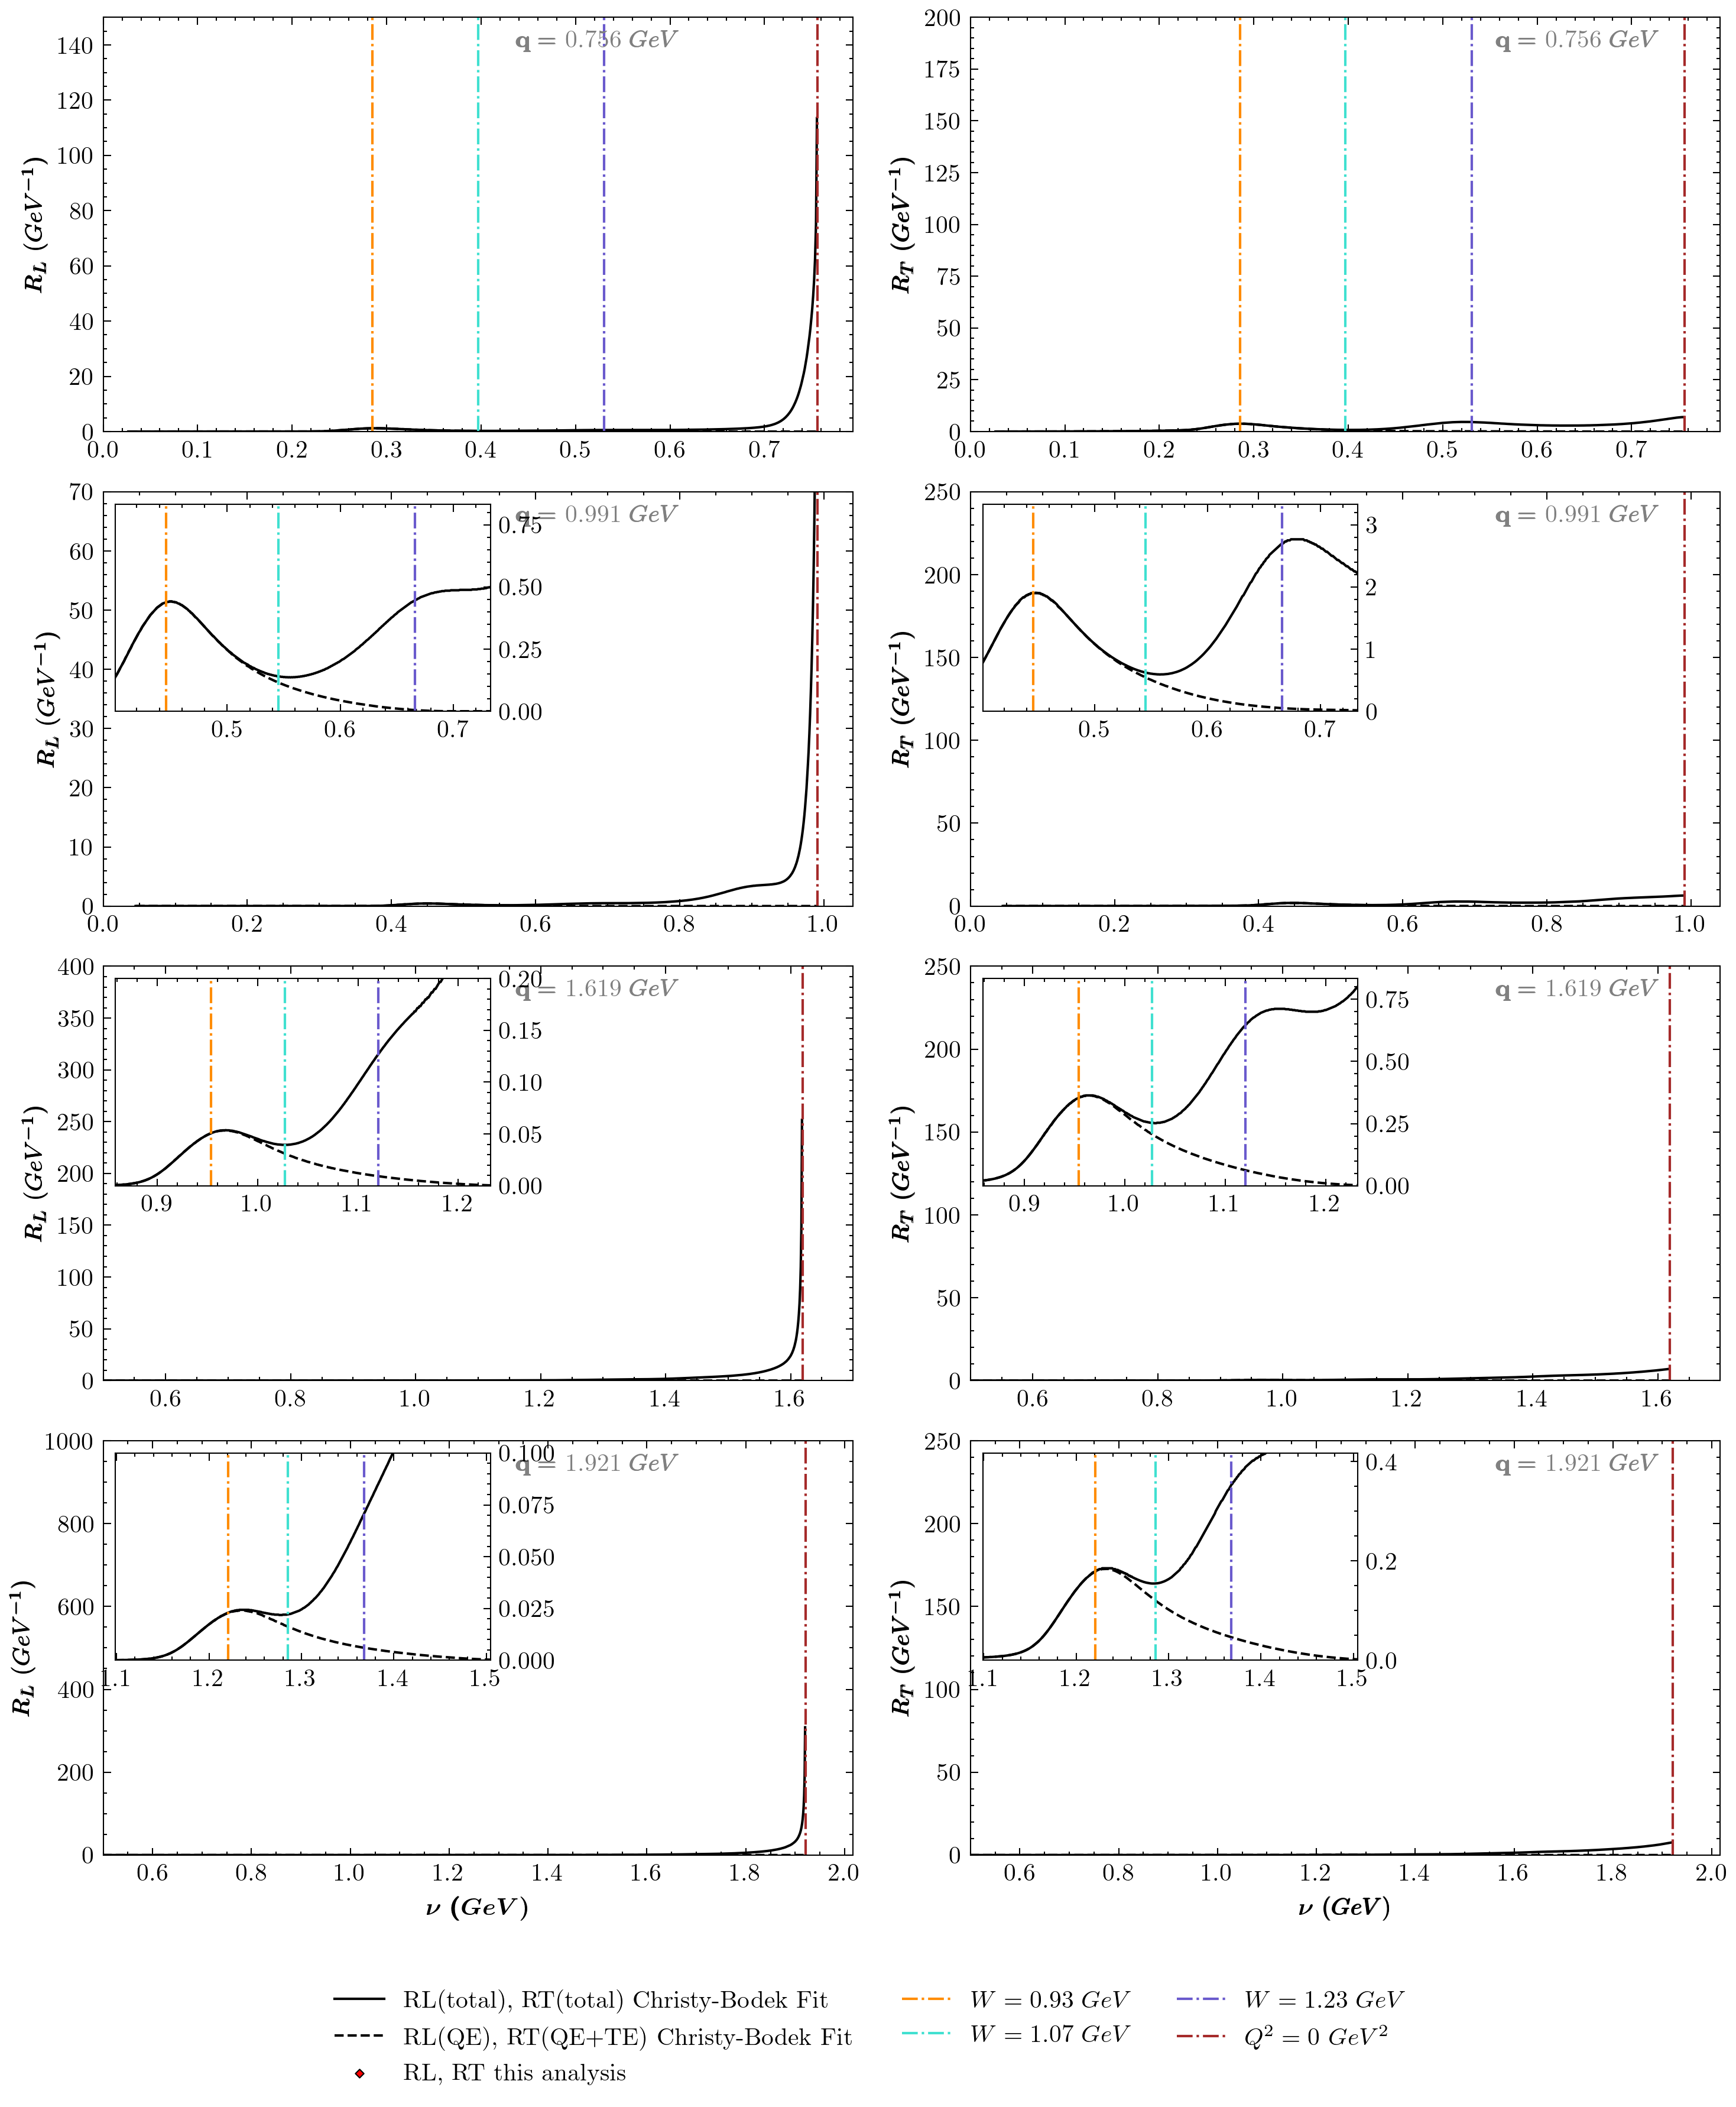

C:\Users\Rhys\AppData\Local\Temp\ipykernel_9836\1669260484.py:274: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


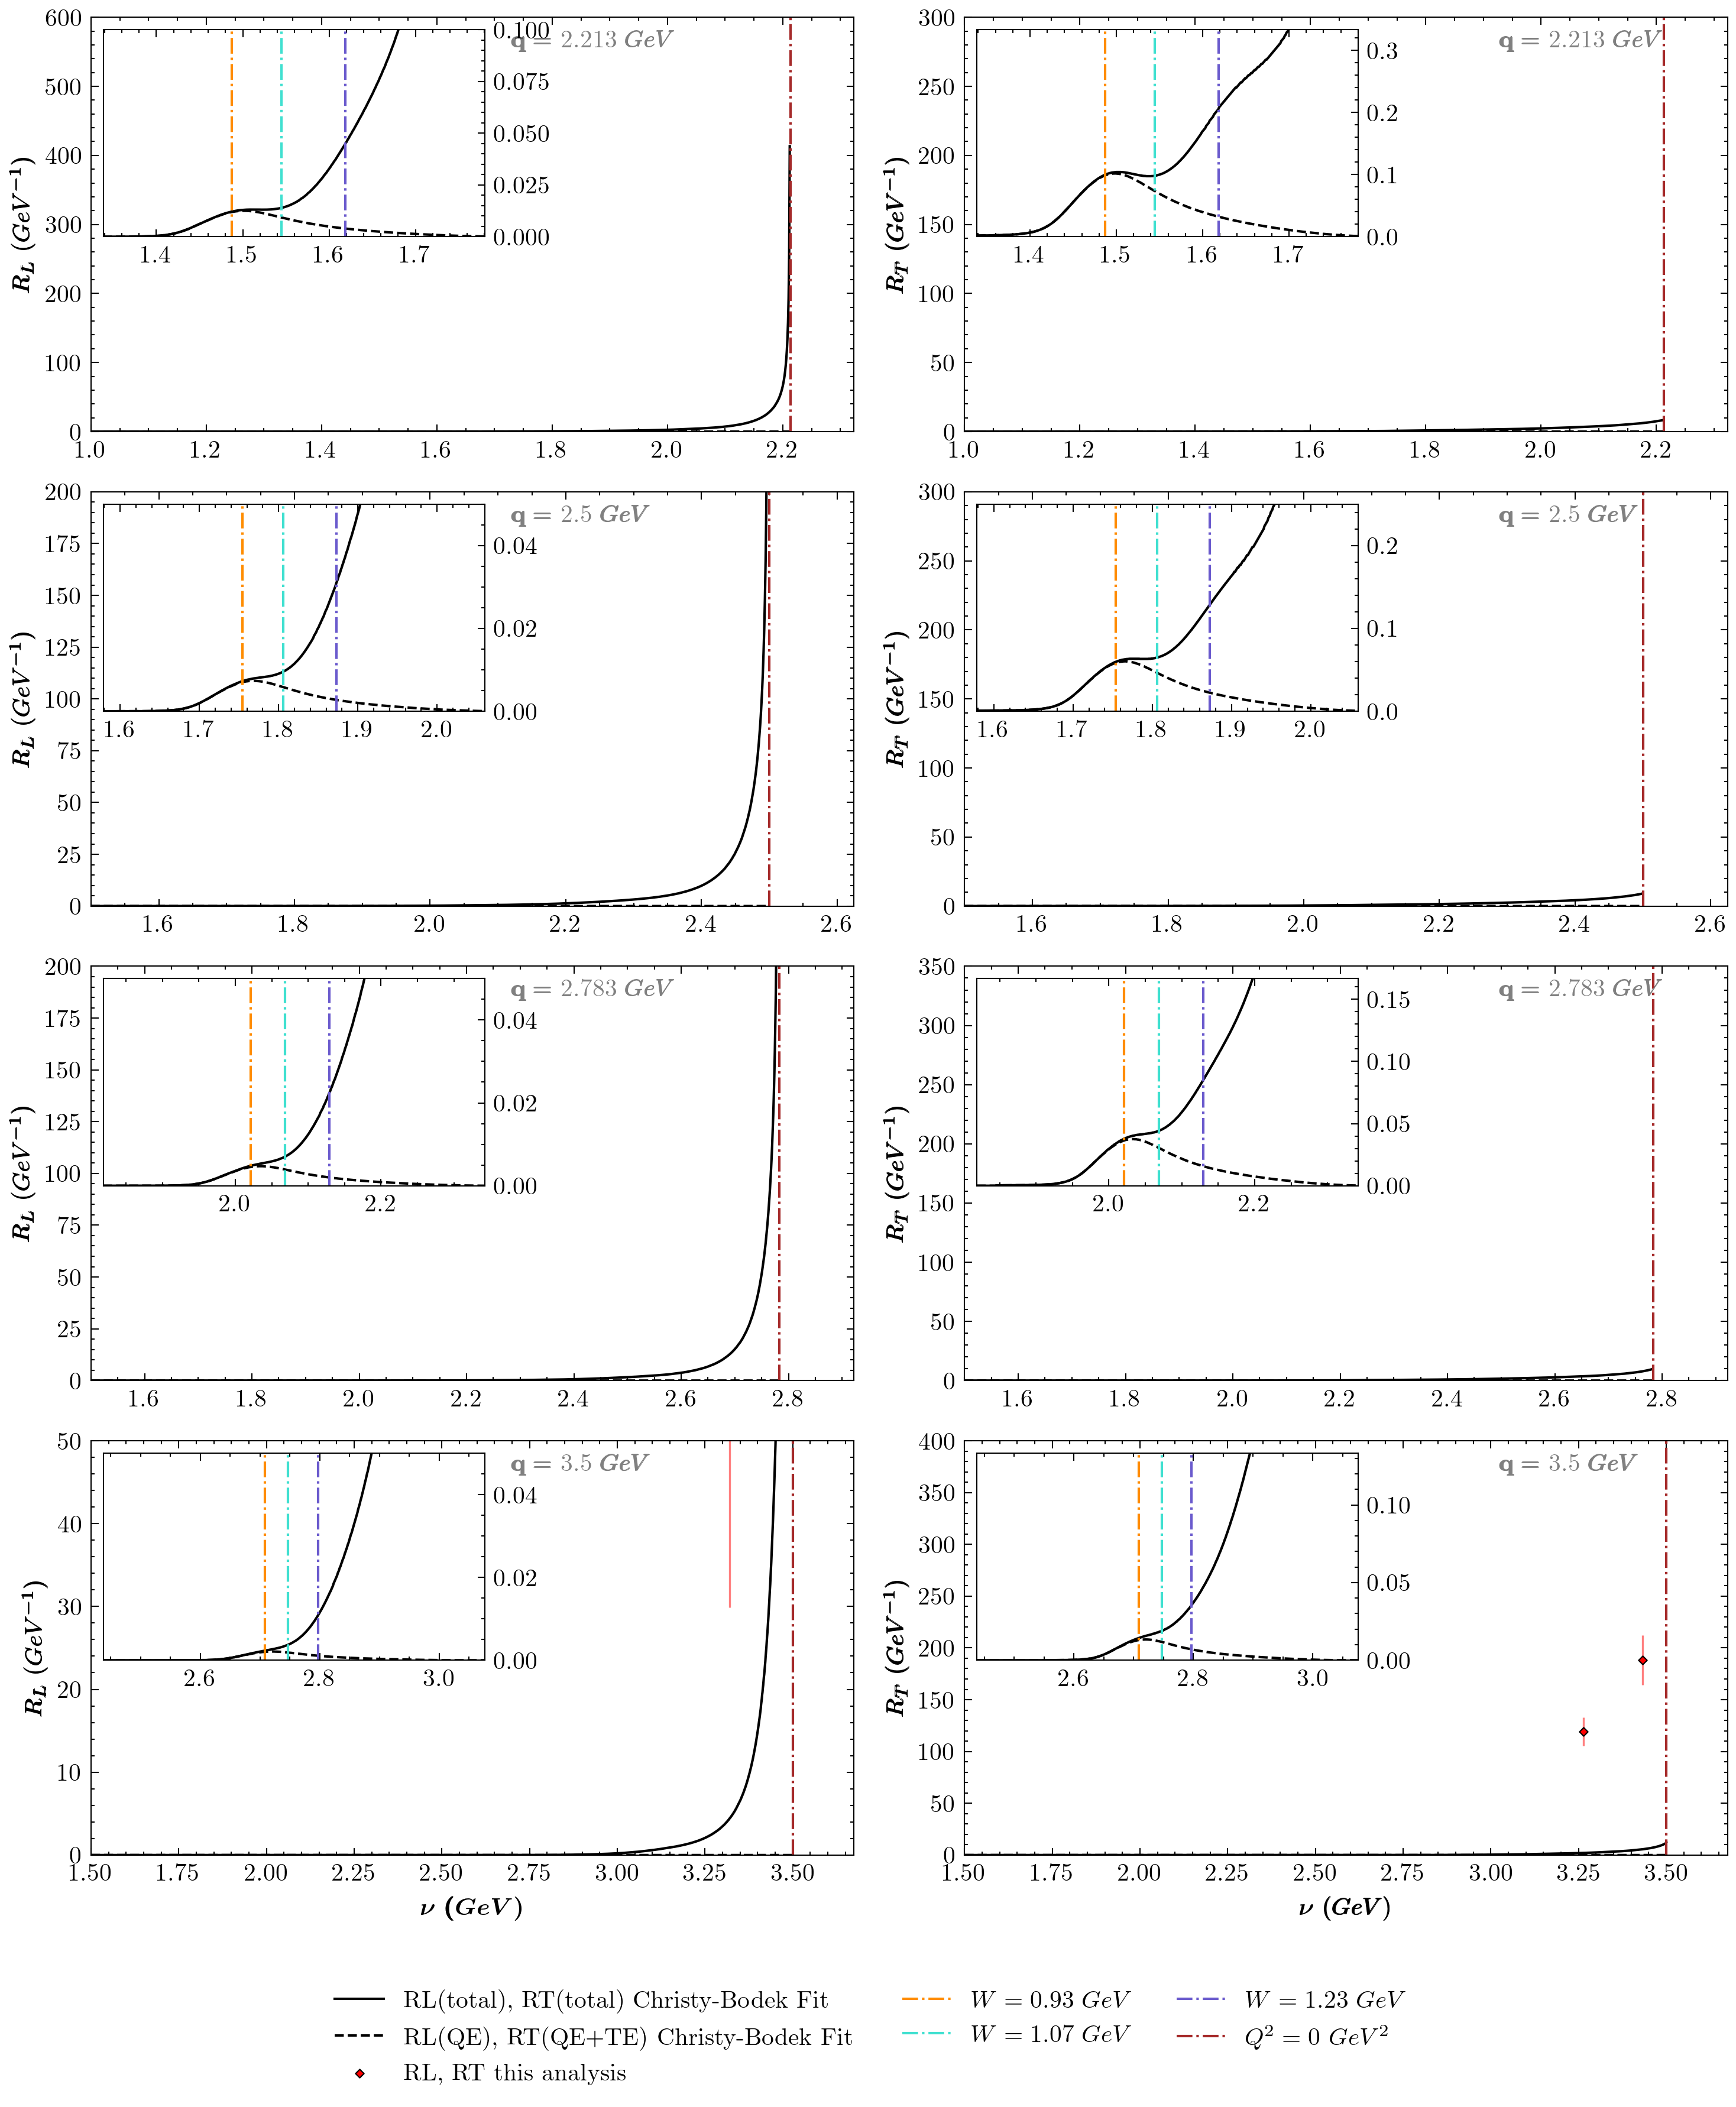

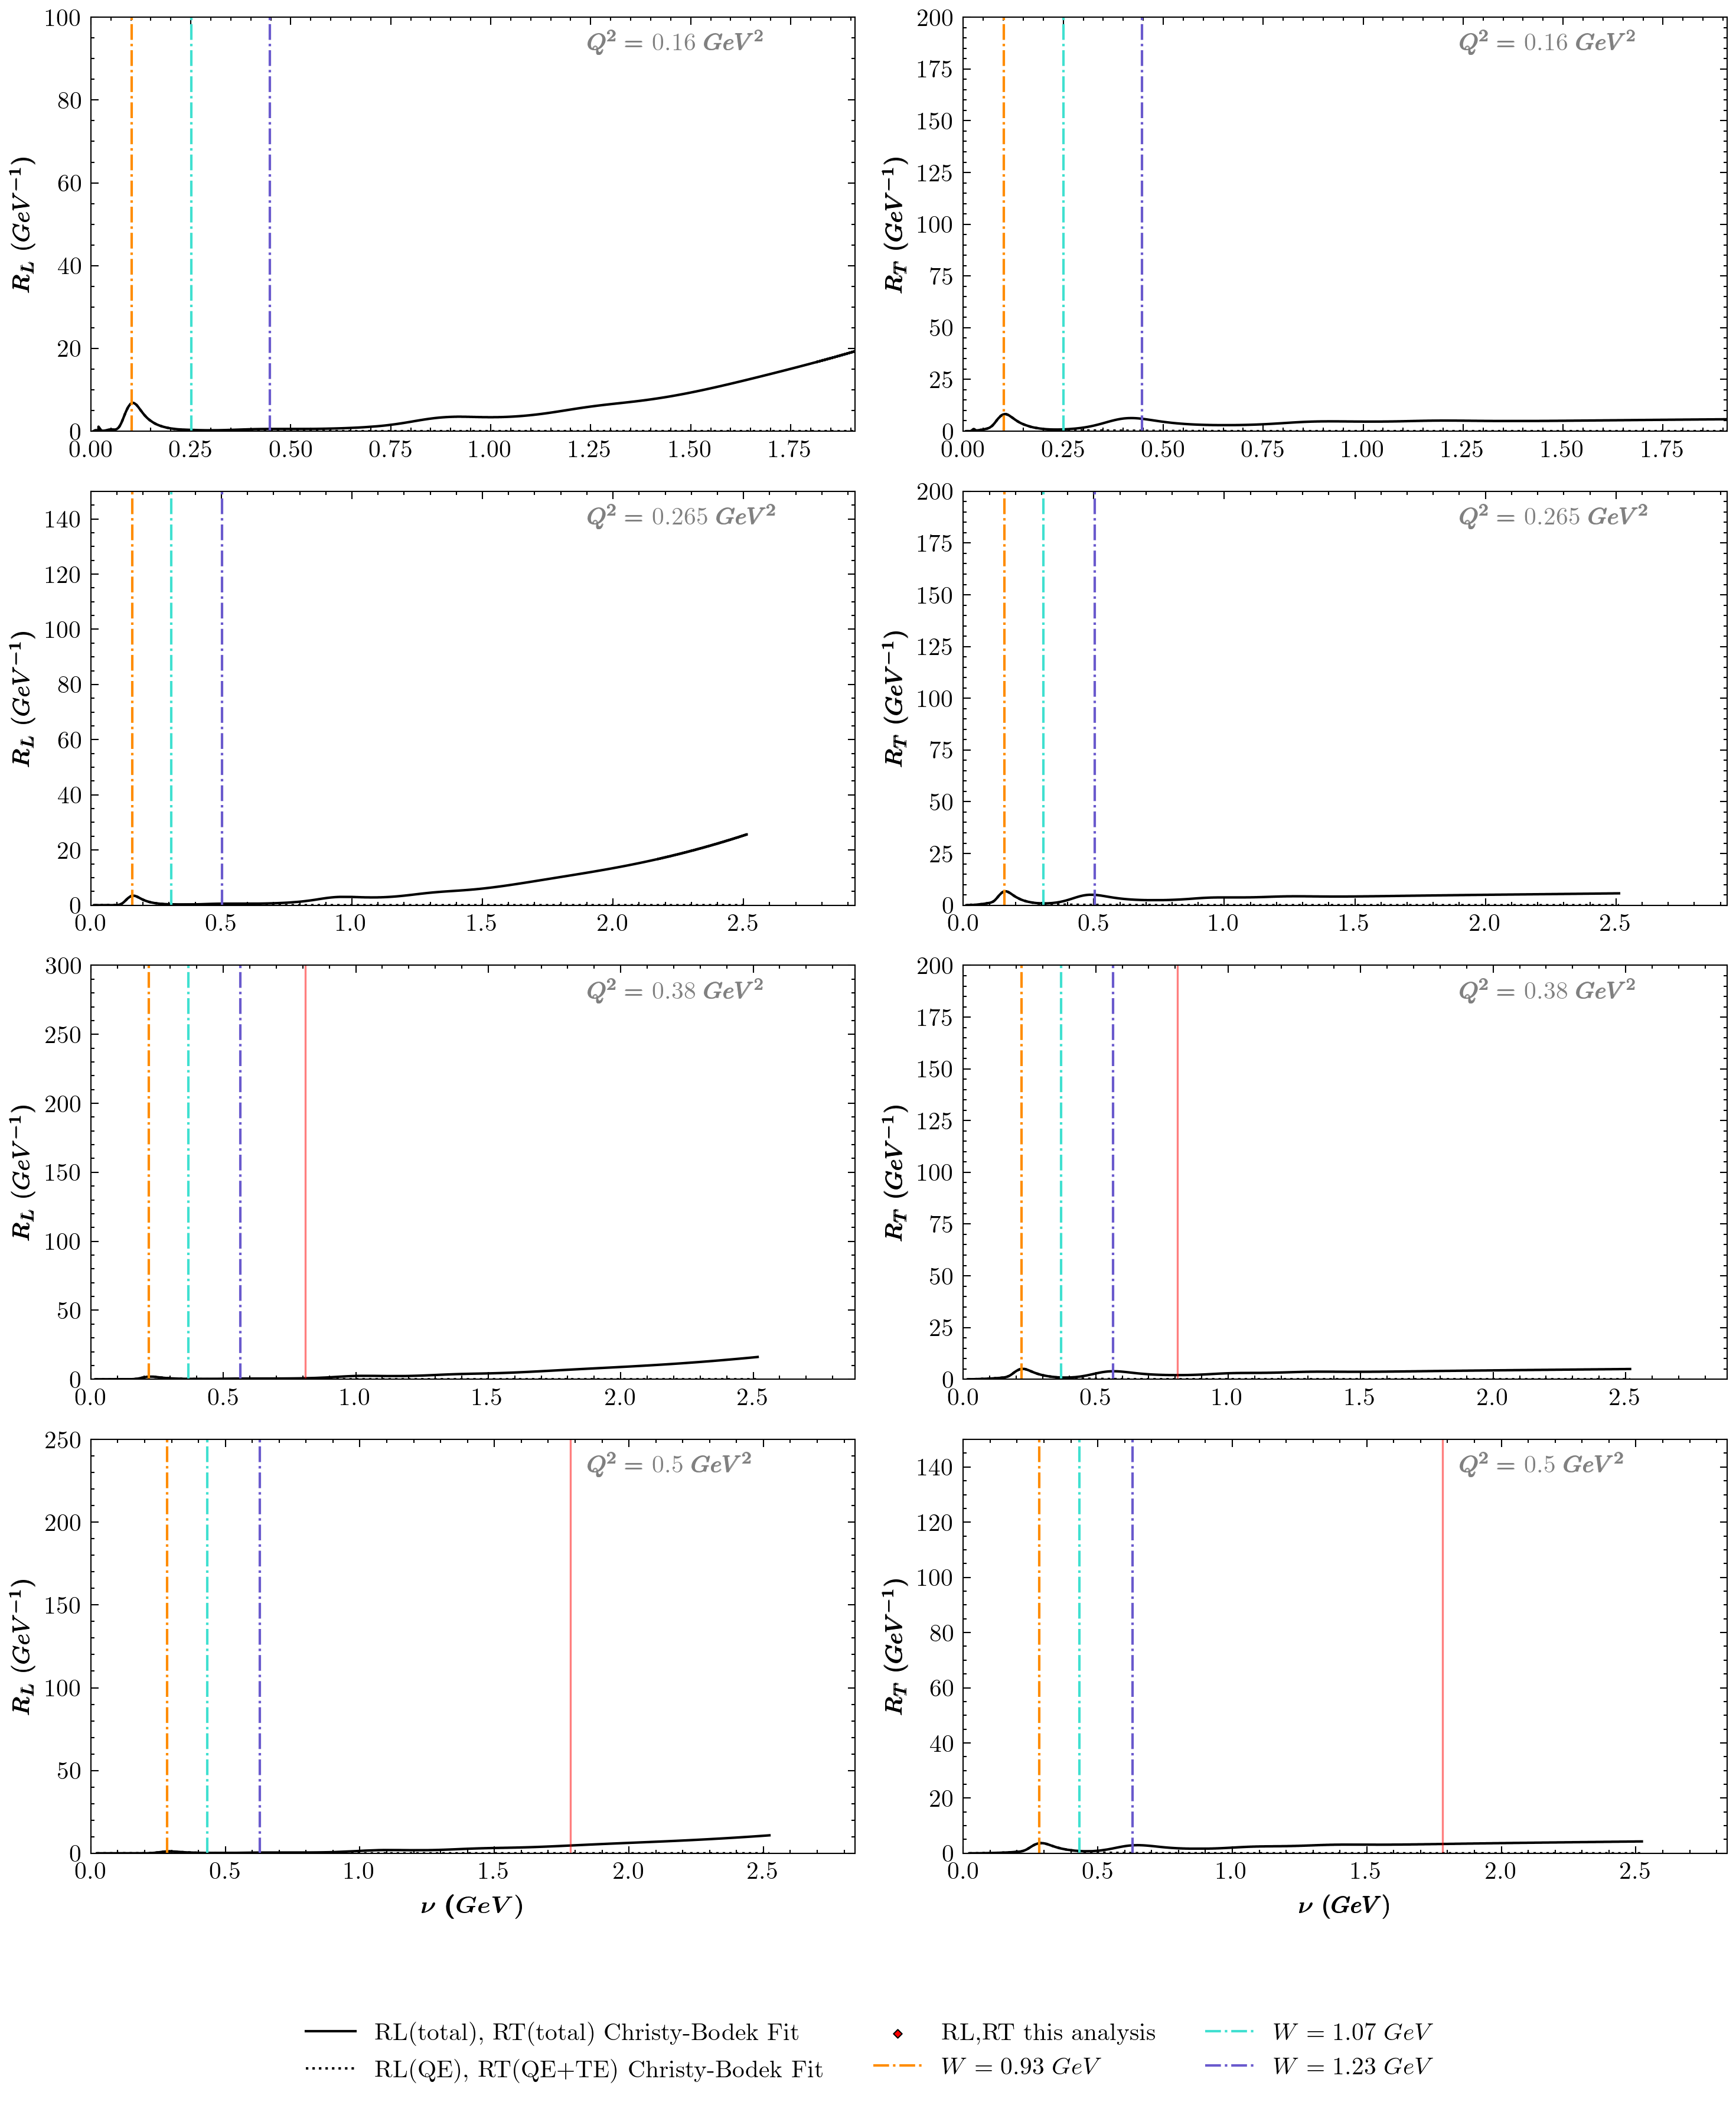

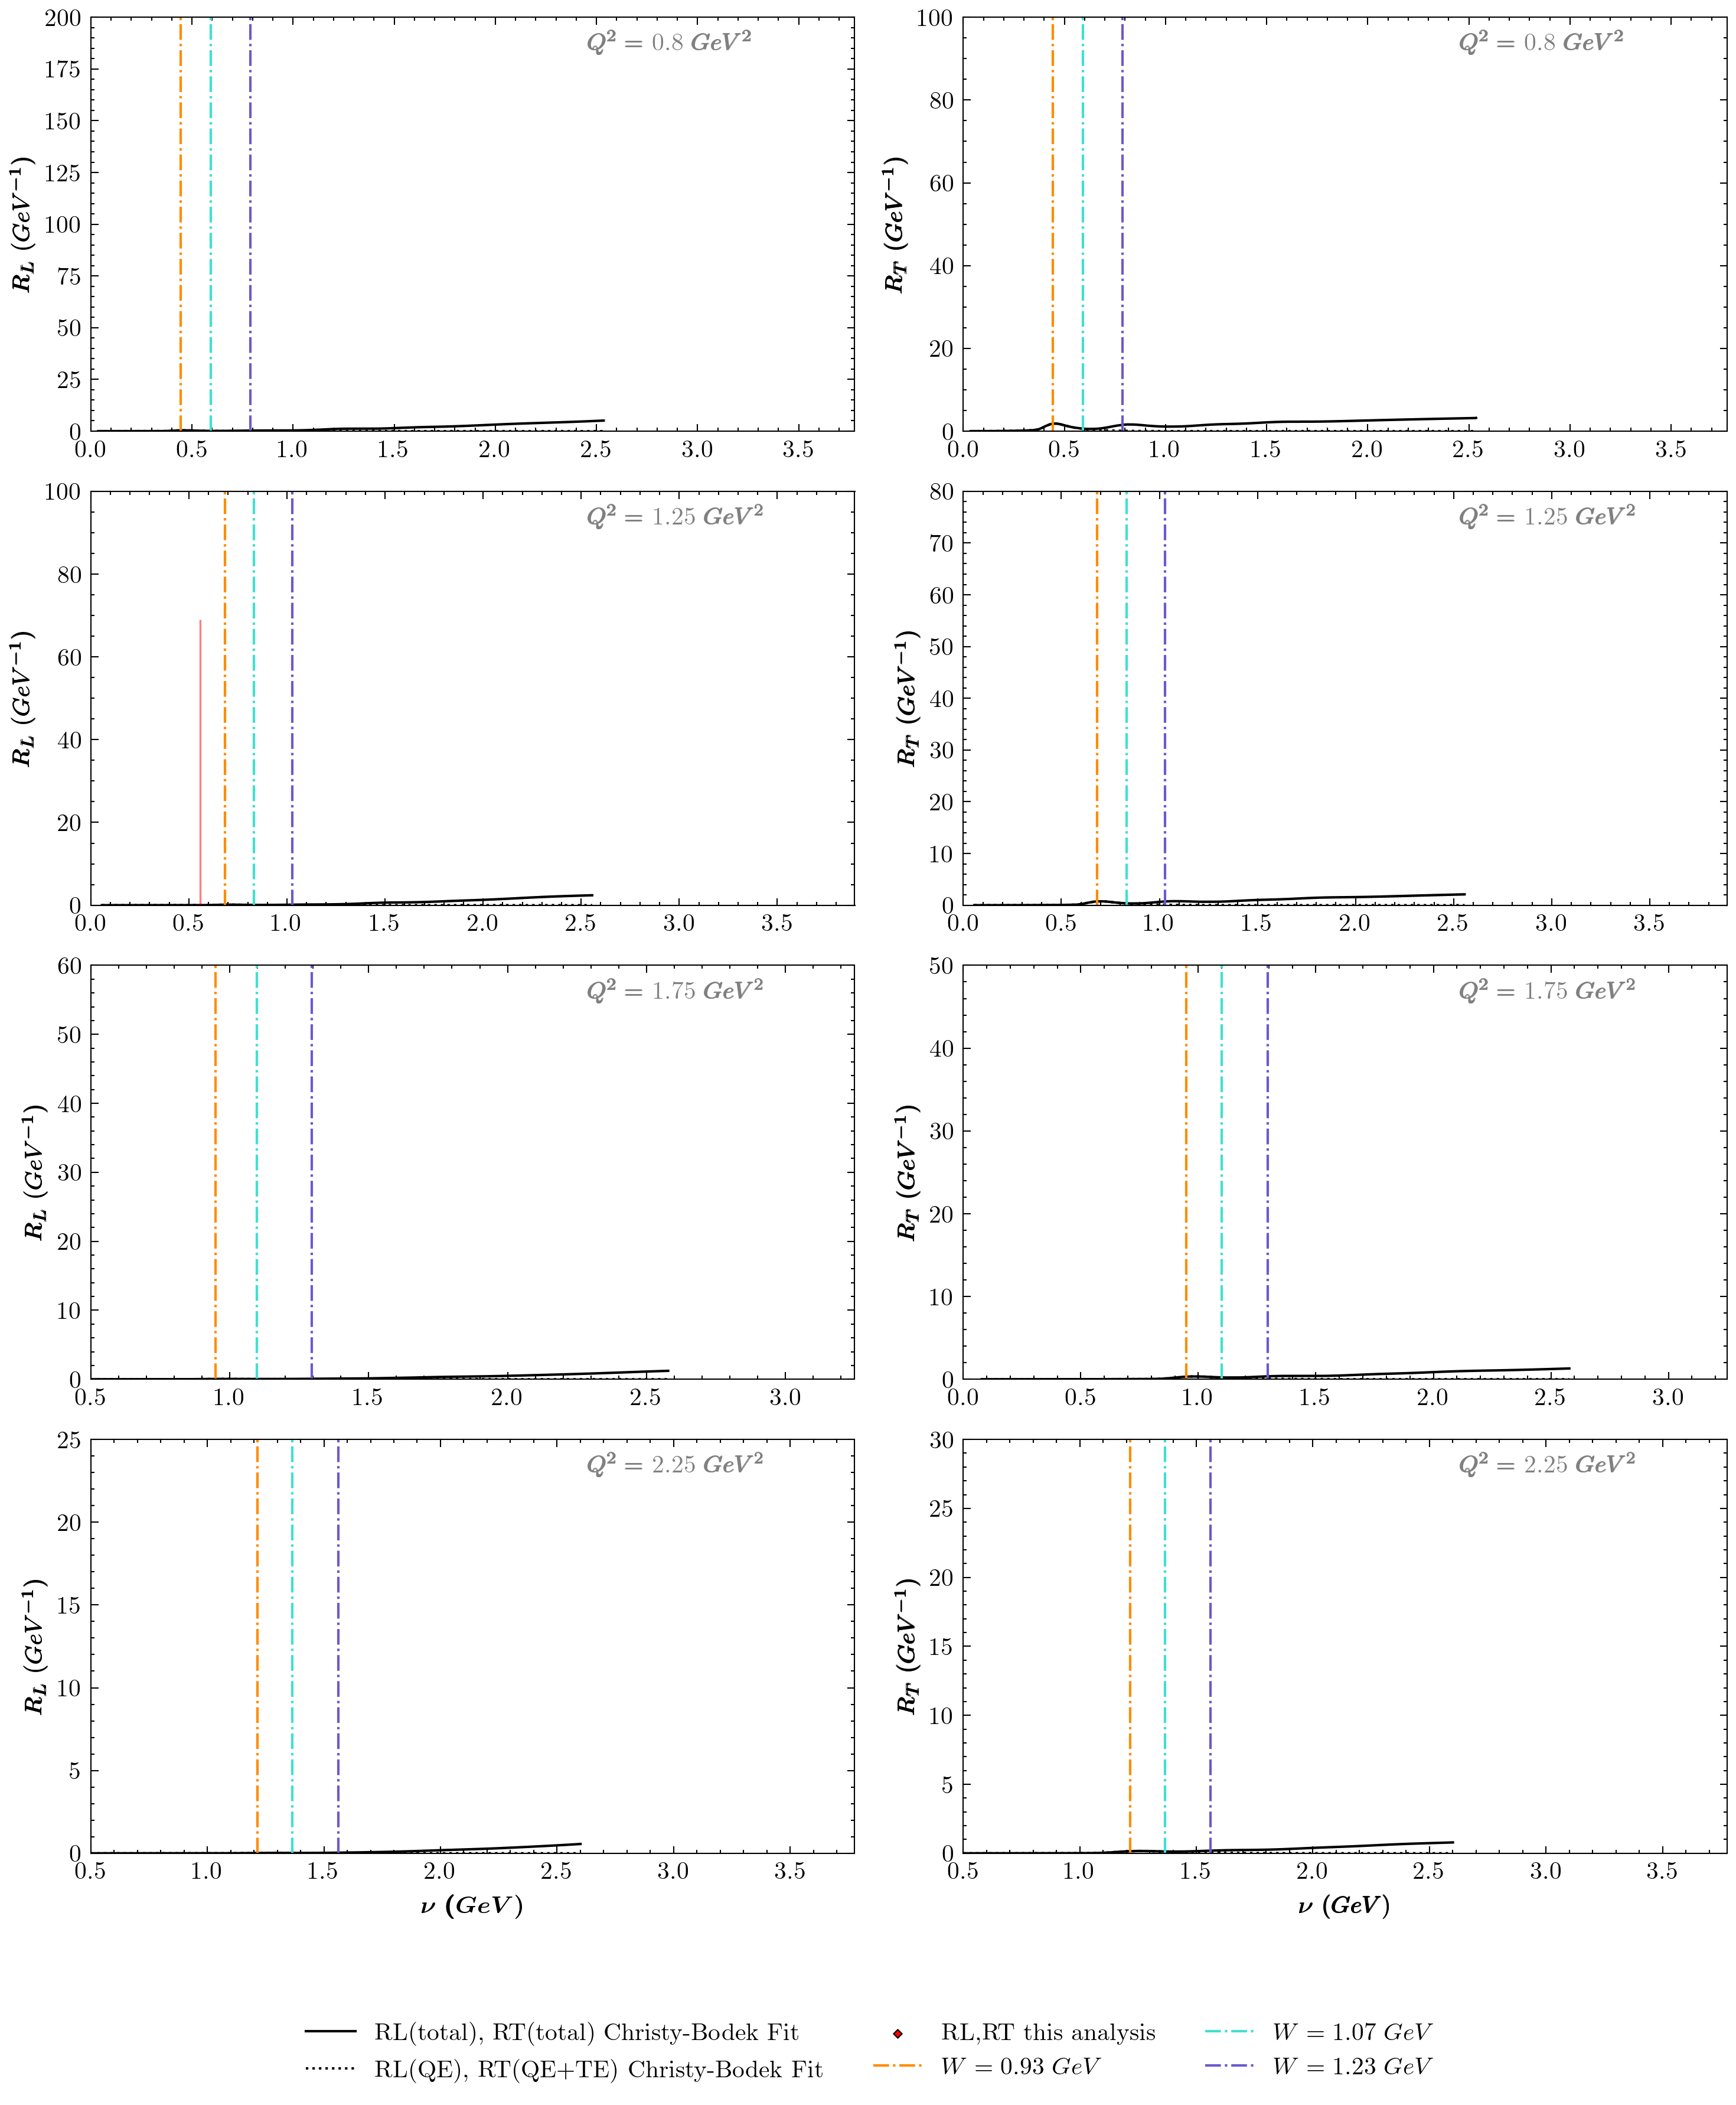

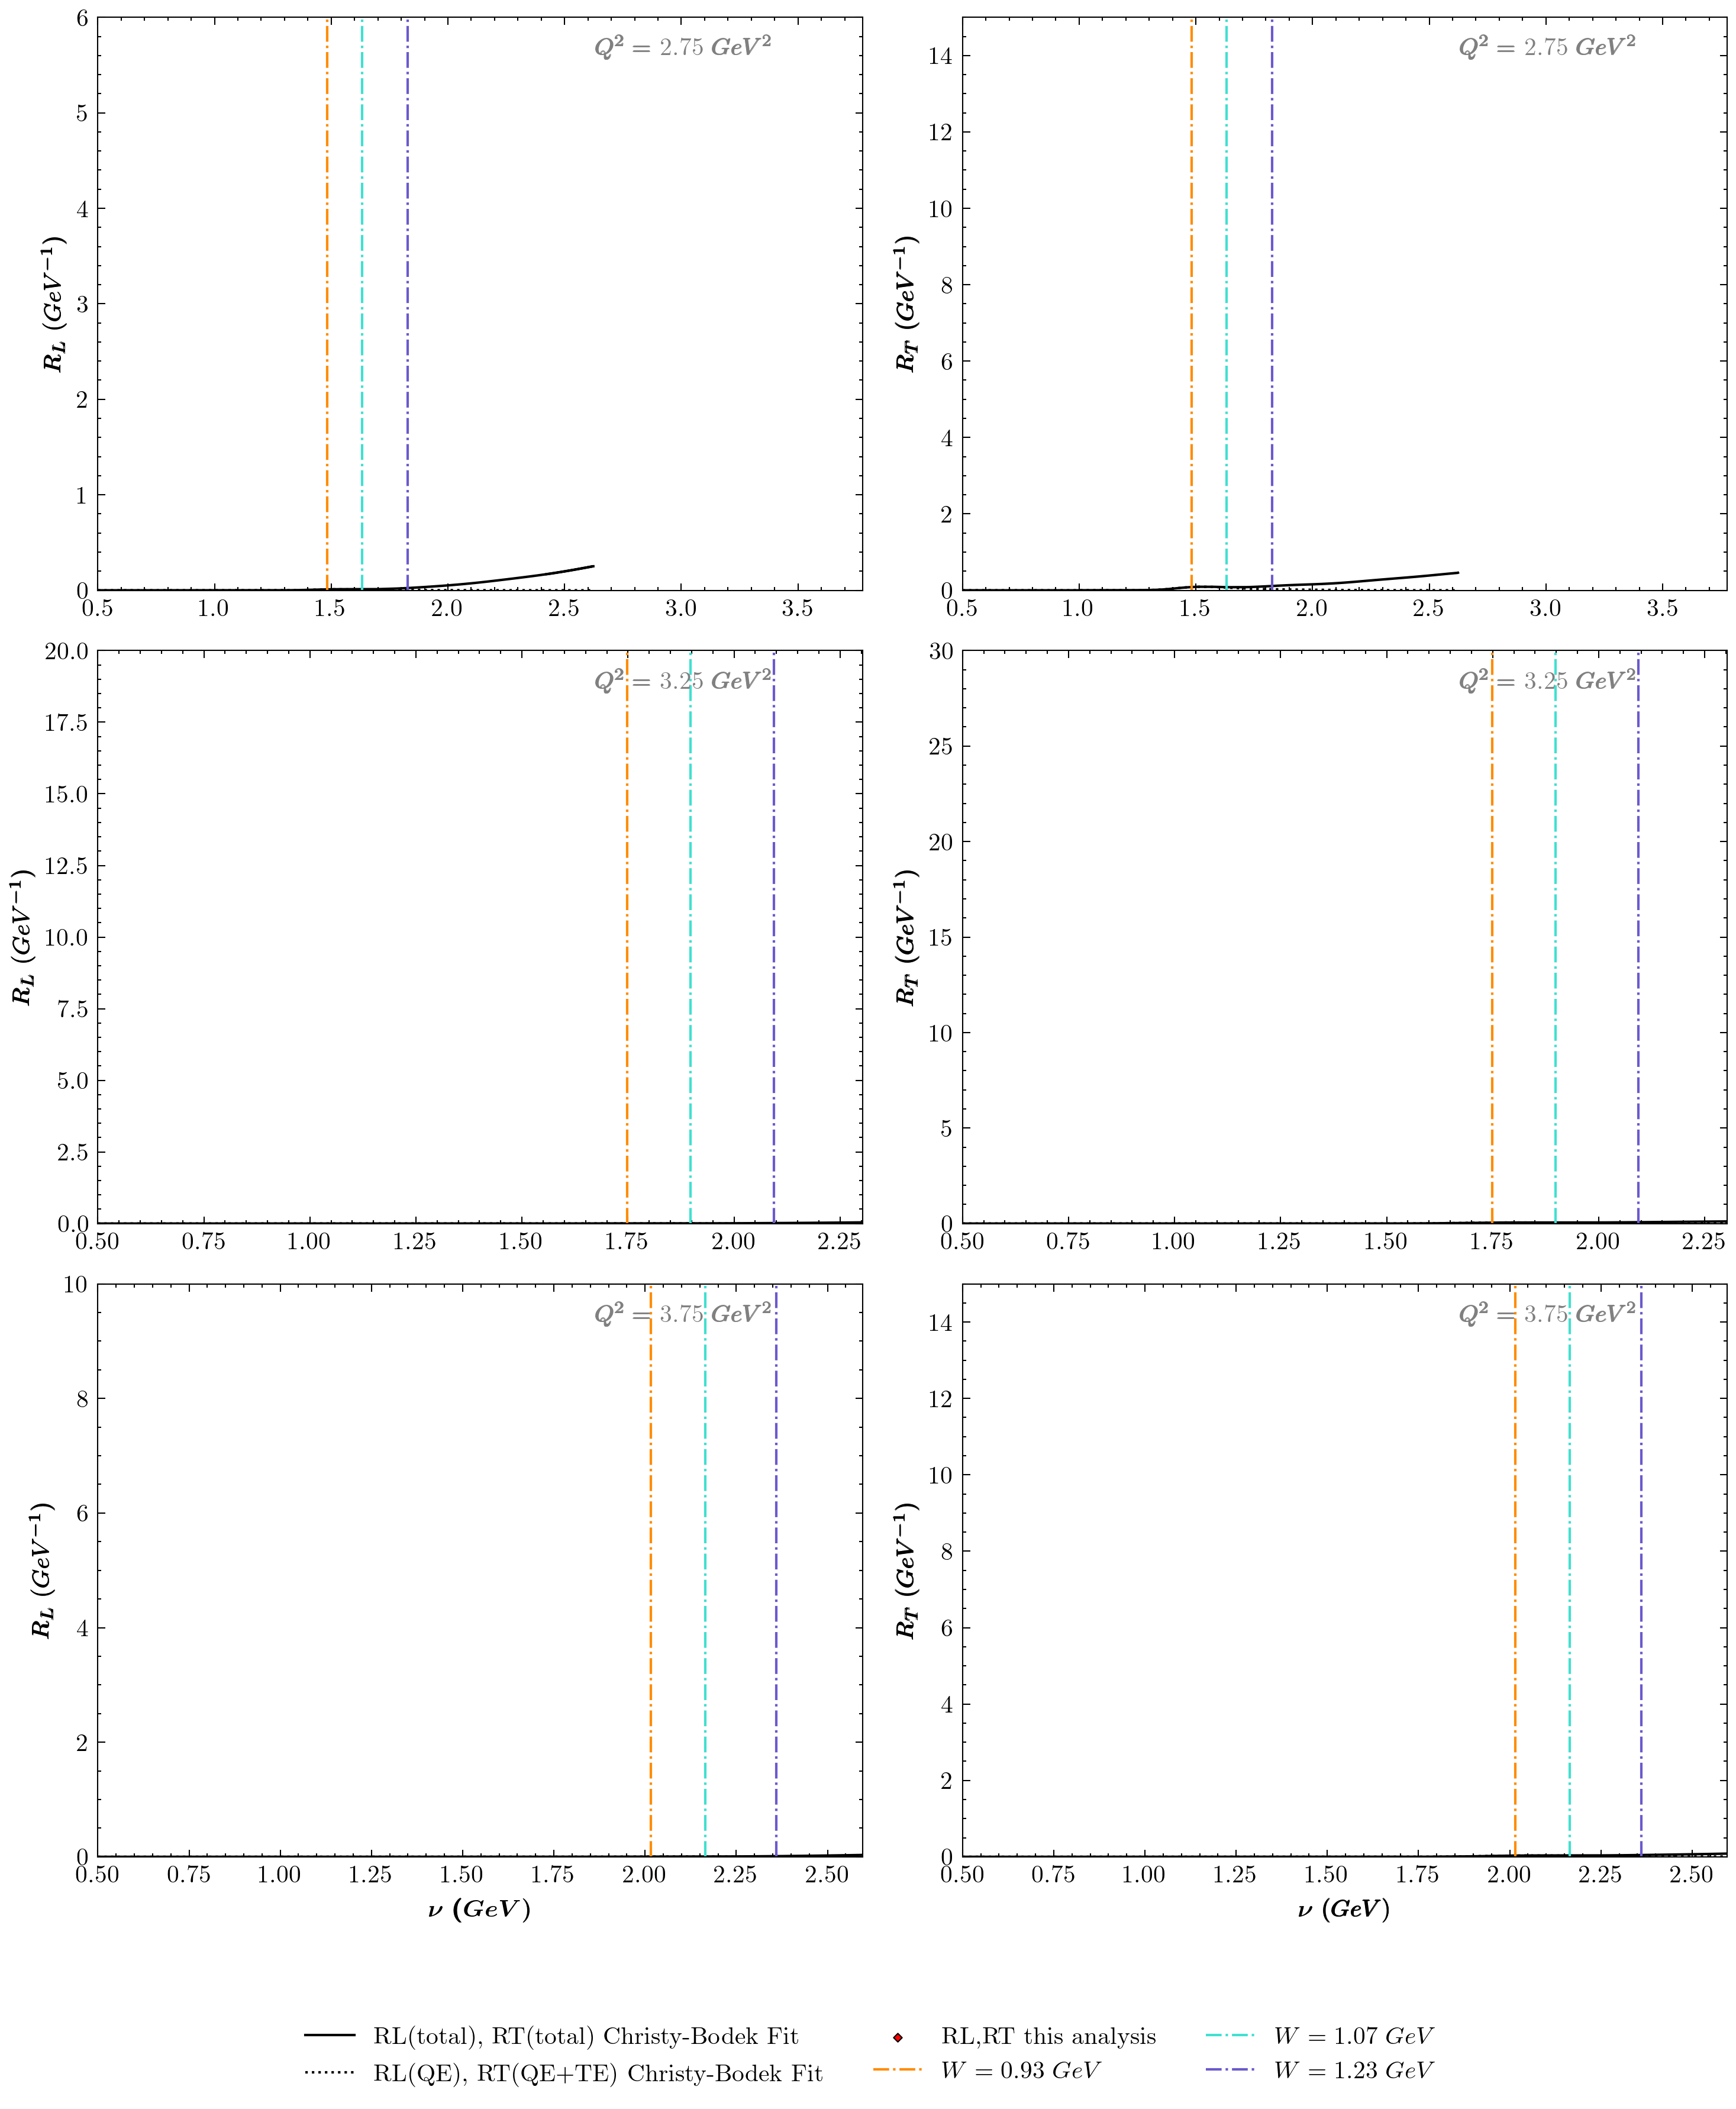

In [7]:
# Plot qvbin
fig1 = RLRT_plot_qvbin(df,bin_indices=[10,11,12,13],figsize=(10,12),subplot_adjust=0.12,legend_ncol=3,RLRTthisAnalysis_plot=True,Rosenbluth_plot=Rosenbluth_pdf_yes,bc=True)
fig2 = RLRT_plot_qvbin(df,bin_indices=[14,15,16,17],figsize=(10,12),subplot_adjust=0.12,legend_ncol=3,RLRTthisAnalysis_plot=True,Rosenbluth_plot=Rosenbluth_pdf_yes,bc=True)

# # Plot Q2bin
fig3 = RLRT_plot_Q2bin(df=df,bin_indices=[7,8,9,10],figsize=(10,12),subplot_adjust=0.12,legend_ncol=3,RLRTthisAnalysis_plot=True,Rosenbluth_plot=Rosenbluth_pdf_yes,bc=True)
fig4 = RLRT_plot_Q2bin(df=df,bin_indices=[11,12,13,14],figsize=(10,12),subplot_adjust=0.12,legend_ncol=3,RLRTthisAnalysis_plot=True,Rosenbluth_plot=Rosenbluth_pdf_yes,bc=True)
fig5 = RLRT_plot_Q2bin(df=df,bin_indices=[15,16,17],figsize=(10,12),subplot_adjust=0.12,legend_ncol=3,RLRTthisAnalysis_plot=True,Rosenbluth_plot=Rosenbluth_pdf_yes,bc=True)

if RLRT_plot_yes:
    fig1.savefig('RLRT_qvbin_1.png')
    fig2.savefig('RLRT_qvbin_2.png')
    fig3.savefig('RLRT_Q2bin_1.png')
    fig4.savefig('RLRT_Q2bin_2.png')
    fig5.savefig('RLRT_Q2bin_3.png')

if RLRT_pdf_yes:
    with PdfPages('Output/H2_RLRT.pdf') as RLRT_pdf:
        RLRT_pdf.savefig(fig1)
        RLRT_pdf.savefig(fig2)
        RLRT_pdf.savefig(fig3)
        RLRT_pdf.savefig(fig4)
        RLRT_pdf.savefig(fig5)

if Rosenbluth_pdf_yes:
    print('Chi2_total = '+str(round(Chi2_total, 3)))
    fig_Chi2_total, ax = plt.subplots()
    ax.axis('off')
    ax.text(0.5, 0.5, 'Chi2_total = '+str(round(Chi2_total, 3)), fontsize=16, ha='center', va='center')
    Rosenbluth_pdf.savefig(fig_Chi2_total)
    Rosenbluth_pdf.close()